In [91]:
import torch

X = torch.normal(0,1,(3,3))

print(X.shape)

print(torch.rand(X.shape))
print(X)

print(torch.zeros_like(X).shape)
print(torch.zeros(X.shape).shape)

torch.Size([3, 3])
tensor([[0.4714, 0.9773, 0.9982],
        [0.7212, 0.8535, 0.4168],
        [0.6867, 0.4773, 0.3664]])
tensor([[ 0.4528, -0.9473, -1.2692],
        [ 1.0717, -1.1399, -0.7426],
        [-0.1362, -1.4227,  1.3150]])
torch.Size([3, 3])
torch.Size([3, 3])


In [92]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    
    if dropout == 1:
        # drop everything
        return torch.zeros_like(X)
    
    if dropout == 0:
        # return everything
        return X
    
    mask = (torch.rand(X.shape) > dropout).float()
    
#     print(mask)
    
    return mask * X /(1.0 - dropout)

In [93]:
dropout_layer(X, 0.6)

tensor([[ 0.0000, -2.3683, -0.0000],
        [ 2.6791, -2.8498, -0.0000],
        [-0.0000, -3.5568,  3.2875]])

In [94]:
dropout_layer(X, 0)

tensor([[ 0.4528, -0.9473, -1.2692],
        [ 1.0717, -1.1399, -0.7426],
        [-0.1362, -1.4227,  1.3150]])

In [95]:
dropout_layer(X,1)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

### Working with fashion mnist

In [96]:
num_inputs, num_outputs , num_hidden1, num_hidden2 = 784, 10, 256, 256

In [97]:
# defining the model probability at each neural layer

dropout1 = 0.2
dropout2 = 0.5

from torch import nn

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2,is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.relu = nn.ReLU()
        self.drop = dropout_layer
    
    def forward(self, X):
        out = self.relu(self.lin1(X.reshape(-1,num_inputs)))
        
        if self.training:
            out = self.drop(out, dropout1)
        
        out = self.relu(self.lin2(out))
        
        if self.training:
            out = self.drop(out, dropout2)
        
        out = self.lin3(out)
        
        return out
        
        

In [98]:
net = Net(num_inputs, num_outputs, num_hidden1, num_hidden2)

In [99]:
X = torch.normal(0,1, (1,784))

In [100]:
net(X)

tensor([[-0.1130, -0.0691, -0.1631,  0.2000, -0.0057, -0.0486, -0.0237, -0.1665,
         -0.0376, -0.0269]], grad_fn=<AddmmBackward>)

In [101]:
import torchvision

my_transforms = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST(root="../data", train=True, download=False, transform=my_transforms)

test_dataset = torchvision.datasets.FashionMNIST(root="../data", train=False, download=False, transform=my_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=256)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=256)


In [102]:
def get_label_from_tensor(y):
    text_labels = [
't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
'sneaker', 'bag', 'ankle boot']
    
    return text_labels[int(y)]

shirt


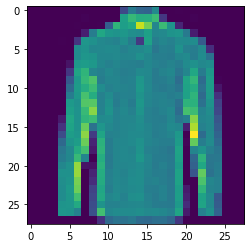

In [103]:
import matplotlib.pyplot as plt

for X,y in train_dataloader:
#     print(X[0].permute(1,2,0).shape)
    plt.imshow(X[0].permute(1,2,0))
    print(get_label_from_tensor(y[0]))
    break

In [104]:
net

Net(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

for epoch 0 train loss : 0.008824554271996021 test loss : 0.009007838554680347
for epoch 1 train loss : 0.008650693111121655 test loss : 0.008849483914673328
for epoch 2 train loss : 0.00844272319227457 test loss : 0.008626350201666355
for epoch 3 train loss : 0.008106465451419353 test loss : 0.008290939033031464
for epoch 4 train loss : 0.007692964281886816 test loss : 0.007851686328649521
for epoch 5 train loss : 0.007129601202905178 test loss : 0.007303530350327492
for epoch 6 train loss : 0.008141444995999336 test loss : 0.008304686285555363
for epoch 7 train loss : 0.008461075834929943 test loss : 0.008650682866573334
for epoch 8 train loss : 0.008109180256724358 test loss : 0.008276134729385376
for epoch 9 train loss : 0.007765485439449549 test loss : 0.007945487275719643


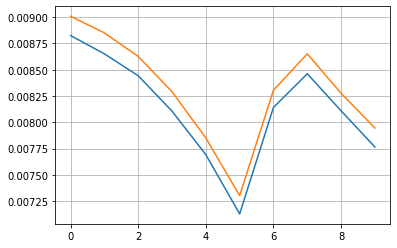

In [105]:
num_epochs, lr, batch_size = 10, 0.5, 256

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

def evaluate_loss(net, train_iter, loss):
    
    with torch.no_grad():
        current_loss =0
        current_number = 0
        net.eval()
        for X , y in train_iter:
            current_loss += loss(net(X), y)
            current_number += len(y)
    
    return current_loss/ current_number

train_loss_array = []
test_loss_array = []

for epoch in range(num_epochs):
    y_hat = net(X)
    l =  loss(y_hat, y)
    
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    
    current_train_loss = evaluate_loss(net, train_dataloader, loss)
    current_test_loss = evaluate_loss(net, test_dataloader, loss)
    
    train_loss_array.append(current_train_loss)
    test_loss_array.append(current_test_loss)
    
    print(f"for epoch {epoch} train loss : {current_train_loss} test loss : {current_test_loss}")
    
     

plt.plot(range(num_epochs), train_loss_array)
plt.plot(range(num_epochs), test_loss_array)
plt.grid(True)
plt.show()
    
    


tensor([[-0.0225, -0.0923, -0.1184, -0.0736, -0.0826,  0.2317, -0.0350,  0.0409,
          0.0295, -0.0075]])
tensor(5)
predicted:  sandal
base_truth: bag


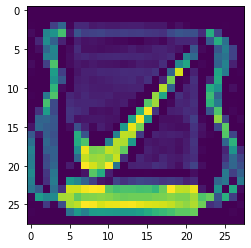

In [106]:
for X, y in test_dataloader:
    break
    
plt.imshow(X[0].permute(1,2,0))

with torch.no_grad():
    print(net(X[0]))

    print(torch.argmax(net(X[0])))

    print("predicted: ", get_label_from_tensor(torch.argmax(net(X[0]))))
    
    print(f"base_truth: {get_label_from_tensor(y[0])}")

### Concise implementation

In [147]:
def evaluate_loss(net, train_iter, loss):
    
    with torch.no_grad():
        current_loss =0
        current_number = 0
        net.eval()
        for X , y in train_iter:
            current_loss += loss(net(X), y)
            current_number += len(y)
    
    return current_loss/ current_number


In [148]:
net_concise = nn.Sequential( nn.Flatten(), nn.Linear(num_inputs, num_hidden1), nn.ReLU(), nn.Dropout(dropout1), nn.Linear(num_hidden1, num_hidden2), nn.ReLU(), nn.Dropout(dropout2),
                     nn.Linear(num_hidden2, num_outputs))

def init_params(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_concise.apply(init_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

predicted (before training):  pullover
base_truth: dress


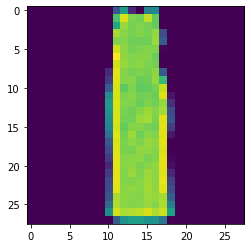

In [149]:
for X, y in test_dataloader:
    break
    
plt.imshow(X[0].permute(1,2,0))

with torch.no_grad():

    print("predicted (before training): ", get_label_from_tensor(torch.argmax(net_concise(X[0].reshape(-1,784)))))
    
    print(f"base_truth: {get_label_from_tensor(y[0])}")

for epoch 0 train loss : 0.009017114527523518 test loss : 0.0092089232057333
for epoch 1 train loss : 0.009014563634991646 test loss : 0.009206241928040981
for epoch 2 train loss : 0.009011943824589252 test loss : 0.009203714318573475
for epoch 3 train loss : 0.009009253233671188 test loss : 0.009200026281177998
for epoch 4 train loss : 0.009006229229271412 test loss : 0.009198094718158245
for epoch 5 train loss : 0.00900256633758545 test loss : 0.00919334962964058
for epoch 6 train loss : 0.008998150005936623 test loss : 0.009188481606543064
for epoch 7 train loss : 0.008992630988359451 test loss : 0.009183131158351898
for epoch 8 train loss : 0.008985462598502636 test loss : 0.009175309911370277
for epoch 9 train loss : 0.008976243436336517 test loss : 0.009165610186755657
for epoch 10 train loss : 0.00896416138857603 test loss : 0.009155617095530033
for epoch 11 train loss : 0.008947690948843956 test loss : 0.0091374097391963
for epoch 12 train loss : 0.008925040252506733 test loss 

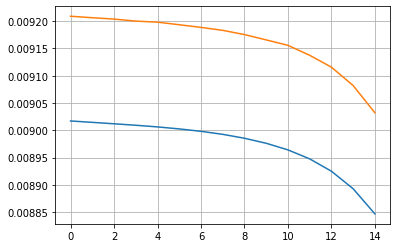

In [150]:
train_loss_array = []
test_loss_array = []

num_epochs, lr, batch_size = 15, 0.5, 256

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_concise.parameters(), lr=lr)


for epoch in range(num_epochs):
    y_hat = net_concise(X)
    l =  loss(y_hat, y)
    
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    
    current_train_loss = evaluate_loss(net_concise, train_dataloader, loss)
    current_test_loss = evaluate_loss(net_concise, test_dataloader, loss)
    
    train_loss_array.append(current_train_loss)
    test_loss_array.append(current_test_loss)
    
    print(f"for epoch {epoch} train loss : {current_train_loss} test loss : {current_test_loss}")
    
     

plt.plot(range(num_epochs), train_loss_array)
plt.plot(range(num_epochs), test_loss_array)
plt.grid(True)
plt.show()


predicted:  trouser
base_truth: bag


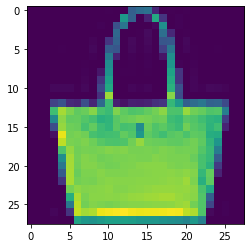

In [151]:
for X, y in test_dataloader:
    break
    
plt.imshow(X[0].permute(1,2,0))

with torch.no_grad():

    print("predicted: ", get_label_from_tensor(torch.argmax(net(X[0].reshape(-1,784)))))
    
    print(f"base_truth: {get_label_from_tensor(y[0])}")

## Exercises
1. What happens if you change the dropout probabilities for the first and second layers? In
particular, what happens if you switch the ones for both layers? Design an experiment to
answer these questions, describe your results quantitatively, and summarize the qualitative
takeaways.
2. Increase the number of epochs and compare the results obtained when using dropout with
those when not using it.
3. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.
4. Why is dropout not typically used at test time?
5. Using the model in this section as an example, compare the effects of using dropout and
weight decay. What happens when dropout and weight decay are used at the same time?
Are the results additive? Are there diminished returns (or worse)? Do they cancel each other
out?
6. What happens if we apply dropout to the individual weights of the weight matrix rather than
the activations?
7. Invent another technique for injecting random noise at each layer that is different from the
standard dropout technique. Can you develop a method that outperforms dropout on the
Fashion-MNIST dataset (for a fixed architecture)?


In [138]:
#1

def design_net(dropout1, dropout2):
    net_concise = nn.Sequential( nn.Flatten(), nn.Linear(num_inputs, num_hidden1), nn.ReLU(), nn.Dropout(dropout1), nn.Linear(num_hidden1, num_hidden2), nn.ReLU(), nn.Dropout(dropout2),
                         nn.Linear(num_hidden2, num_outputs))

    def init_params(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    net_concise.apply(init_params)
    
    return net_concise

In [142]:
def train_net_and_plot(net, num_epochs=8):
    train_loss_array = []
    test_loss_array = []

    lr, batch_size = 0.5, 256

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net_concise.parameters(), lr=lr)


    for epoch in range(num_epochs):
        y_hat = net_concise(X)
        l =  loss(y_hat, y)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        current_train_loss = evaluate_loss(net_concise, train_dataloader, loss)
        current_test_loss = evaluate_loss(net_concise, test_dataloader, loss)

        train_loss_array.append(current_train_loss)
        test_loss_array.append(current_test_loss)

#         print(f"for epoch {epoch} train loss : {current_train_loss} test loss : {current_test_loss}")



    plt.plot(range(num_epochs), train_loss_array)
    plt.plot(range(num_epochs), test_loss_array)
    plt.grid(True)
    plt.show()
    print(f"final train loss : {current_train_loss} test loss : {current_test_loss}")



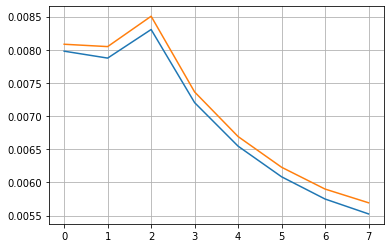

final train loss : 0.005525681190192699 test loss : 0.005693717394024134


In [143]:
train_net_and_plot(design_net(0.2, 0.6))

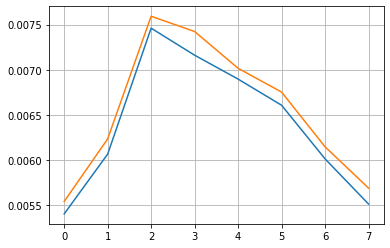

final train loss : 0.005515171680599451 test loss : 0.00569165451452136


In [144]:
train_net_and_plot(design_net(0.6, 0.2))

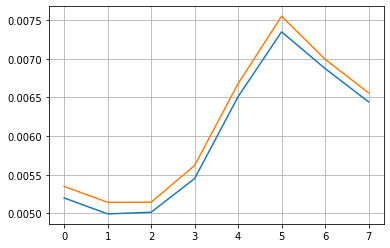

final train loss : 0.00644347770139575 test loss : 0.006559249013662338


In [145]:
#2 

# trying to find the dropout use

train_net_and_plot(design_net(0, 0))

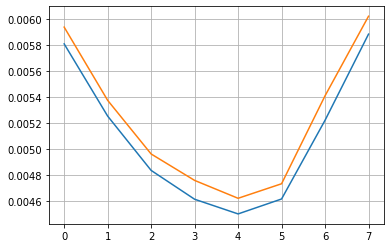

final train loss : 0.005884850863367319 test loss : 0.006022132001817226


In [146]:
train_net_and_plot(design_net(1,1))

In [ ]:
# 4

# not used at runtime because we want that dropout not to take out features that are important